The Semi-Supervised GAN, or sometimes SGAN for short, is an extension of the Generative Adversarial Network architecture for addressing semi-supervised learning problems.

The discriminator in a traditional GAN is trained to predict whether a given image is real (from the dataset) or fake (generated), allowing it to learn features from unlabeled images. The discriminator can then be used via transfer learning as a starting point when developing a classifier for the same dataset, allowing the supervised prediction task to benefit from the unsupervised training of the GAN.

In the Semi-Supervised GAN, the discriminator model is updated to predict K+1 classes, where K is the number of classes in the prediction problem and the additional class label is added for a new “fake” class. It involves directly training the discriminator model for both the unsupervised GAN task and the supervised classification task simultaneously.

Training in unsupervised mode allows the model to learn useful feature extraction capabilities from a large unlabeled dataset, whereas training in supervised mode allows the model to use the extracted features and apply class labels.

The result is a classifier model that can achieve state-of-the-art results on standard problems such as MNIST when trained on very few labeled examples, such as tens, hundreds, or one thousand. Additionally, the training process can also result in better quality images output by the generator model.

**Import essential libraries:**

In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy import prod
from numpy import reshape
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
import tensorflow as tf
import keras.optimizers
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from matplotlib import pyplot
from keras import backend

**Custom activation Function:**

In [2]:
def custom_activation(output):
	logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
	result = logexpsum / (logexpsum + 1.0)
	return result

**Standalone supervised and unsupervised discriminator models:**

Starting with the standard GAN discriminator model, we can update it to create two models that share feature extraction weights.

Specifically, we can define one classifier model that predicts whether an input image is real or fake, and a second classifier model that predicts the class of a given model.

* Binary Classifier Model. Predicts whether the image is real or fake, sigmoid activation function in the output layer, and optimized using the binary cross entropy loss function.
* Multi-Class Classifier Model. Predicts the class of the image, softmax activation function in the output layer, and optimized using the sparse categorical cross entropy loss function.


Both models have different output layers but share all feature extraction layers. This means that updates to one of the classifier models will impact both models.

In [3]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
  # image input
	in_image = Input(shape=in_shape)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output layer nodes
	fe = Dense(n_classes)(fe)
	# supervised output
	c_out_layer = Activation('softmax')(fe)
	# define and compile supervised discriminator model
	c_model = Model(in_image, c_out_layer)
	c_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
	# unsupervised output
	d_out_layer = Lambda(custom_activation)(fe)
	# define and compile unsupervised discriminator model
	d_model = Model(in_image, d_out_layer)
	d_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
	return d_model, c_model

**Define the standalone generator models:**

The generator model will take as input a point in the latent space and will use transpose convolutional layers to output a 28×28 grayscale image. The generator model will be fit via the unsupervised discriminator model.

In [4]:
def define_generator(latent_dim):
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model(in_lat, out_layer)
	return model

**Define the combined generator and discriminate model, for updating the generator:**

We will use the composite model architecture, common to training the generator model when implemented in Keras. Specifically, weight sharing is used where the output of the generator model is passed directly to the unsupervised discriminator model, and the weights of the discriminator are marked as not trainable.

The define_gan() function below implements this, taking the already-defined generator and discriminator models as input and returning the composite model used to train the weights of the generator model.

In [5]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect image output from generator as input to discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and outputting a classification
	model = Model(g_model.input, gan_output)
	# compile model
	opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

**Load the images:**

Load the training dataset and scale the pixels to the range [-1, 1] to match the output values of the generator model.

In [6]:
def load_real_samples():
	# load dataset
  (trainX, trainy), (testX, testy) = load_data()
  # expand to 3d, e.g. add channels
  trainX = expand_dims(trainX, axis=-1)
  testX = expand_dims(testX, axis=-1)
  # convert from ints to floats
  trainX = trainX.astype('float32')
  testX = testX.astype('float32')
  # scale from [0,255] to [-1,1]
  trainX = (trainX - 127.5) / 127.5
  testX = (testX - 127.5) / 127.5

  return [trainX, trainy], [testX, testy]

**Select a supervised subset of the dataset with balanced classes:**

Select a subset of the training dataset in which we keep the labels and train the supervised version of the discriminator model.

This function is careful to ensure that the selection of examples is random and that the classes are balanced. The number of labeled examples is parameterized and set at 100, meaning that each of the 10 classes will have 10 randomly selected examples.

In [7]:
def select_supervised_samples(dataset, n_samples= 100, n_classes=10):
	X, y = dataset
	X_list, y_list = list(), list()
	n_per_class = int(n_samples / n_classes)
	for i in range(n_classes):
		# get all images for this class
		X_with_class = X[y == i]
		# choose random instances
		ix = randint(0, len(X_with_class), n_per_class)
		# add to list
		[X_list.append(X_with_class[j]) for j in ix]
		[y_list.append(i) for j in ix]
	return asarray(X_list), asarray(y_list)

**Select real samples:**

A sample of images and labels is selected, with replacement. This same function can be used to retrieve examples from the labeled and unlabeled dataset, later when we train the models. In the case of the “unlabeled dataset“, we will ignore the labels.

In [8]:
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

**Generate points in latent space as input for the generator:**

First, the generate_latent_points() function will create a batch worth of random points in the latent space that can be used as input for generating images. The generate_fake_samples() function will call this function to generate a batch worth of images that can be fed to the unsupervised discriminator model or the composite GAN model during training.

In [9]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	z_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = z_input.reshape(n_samples, latent_dim)
	return z_input

**Use the generator to generate n fake examples, with class labels:**

In [10]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1))
	return images, y

**Generate samples for drawing plot:**

In [11]:
def summarize_performance(step, g_model, c_model, latent_dim, dataset, n_samples=100):
	# prepare fake examples
	global X
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# evaluate the classifier model
	X, y = dataset
	_, acc = c_model.evaluate(X, y, verbose=0)
	print('Classifier Accuracy: %.3f%%' % (acc * 100))

**Train the generator and discriminator:**

We can define a function to train the models. The defined models and loaded training dataset are provided as arguments, and the number of training epochs and batch size are arbitrary.

The chosen model configuration was found to overfit the training dataset quickly, hence the relatively smaller number of training epochs. Increasing the epochs to 100 or more results in much higher-quality generated images, but a lower-quality classifier model. Balancing these two concerns might make a fun extension.

First, the labeled subset of the training dataset is selected, and the number of training steps is calculated.

A single cycle through updating the models involves first updating the supervised discriminator model with labeled examples, then updating the unsupervised discriminator model with unlabeled real and generated examples. Finally, the generator model is updated via the composite model.

The shared weights of the discriminator model get updated with 1.5 batches worth of samples, whereas the weights of the generator model are updated with one batch worth of samples each iteration. Changing this so that each model is updated by the same amount might improve the model training process.

In [12]:
def train(g_model, d_model, c_model, gan_model, dataset, latent_dim, n_epochs, n_batch=100):
	# select supervised dataset
	X_sup, y_sup = select_supervised_samples(dataset)
	print(X_sup.shape, y_sup.shape)
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
	# manually enumerate epochs
	for i in range(n_steps):
		# update supervised discriminator (c)
		[Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
		c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
		# update unsupervised discriminator (d)
		[X_real, _], y_real = generate_real_samples(dataset, half_batch)
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# update generator (g)
		X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, g_model, c_model, latent_dim, dataset)

**Size of the latent space:**

In [13]:
latent_dim = 100

**Create the discriminator models:**

In [14]:
d_model, c_model = define_discriminator()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Create the generator:**

In [15]:
g_model = define_generator(latent_dim)

**Create the gan:**

In [16]:
gan_model = define_gan(g_model, d_model)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Load image data:**

In [17]:
train_dataset, test_dataset = load_real_samples()

11501568/11490434 [==============================] - 0s 0us/step


**Train model:**

In [18]:
train(g_model, d_model, c_model, gan_model, train_dataset, latent_dim, 5)

(100, 28, 28, 1) (100,)
n_epochs=5, n_batch=100, 1/2=50, b/e=600, steps=3000
Classifier Accuracy: 84.958%
Classifier Accuracy: 90.307%
Classifier Accuracy: 91.758%
Classifier Accuracy: 92.840%
Classifier Accuracy: 93.195%


In [19]:
_, acc = c_model.evaluate(test_dataset[0], test_dataset[1], verbose=0)
print('Accuracy: %.3f%%' % (acc * 100))

Accuracy: 93.860%


**Compile CNN:**

In [20]:
def model_compile(loss, optimizer, batch_s):

    X_train, y_train = select_supervised_samples(train_dataset)
    
    model.compile(loss = loss,
                 optimizer = optimizer,
                 metrics = ['accuracy'])
    
    global model_history
    model_history = model.fit(X_train, y_train, epochs=500, batch_size = batch_s)

In [21]:
model = keras.models.Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), strides=1, activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=16, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))


model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [22]:
model_compile('sparse_categorical_crossentropy', 'adam', 32)

Epoch 1/500
4/4 [==============================] - 2s 70ms/step - loss: 3.0396 - accuracy: 0.0800
Epoch 2/500
4/4 [==============================] - 0s 6ms/step - loss: 2.2183 - accuracy: 0.2600
Epoch 3/500
4/4 [==============================] - 0s 6ms/step - loss: 2.2061 - accuracy: 0.2800
Epoch 4/500
4/4 [==============================] - 0s 6ms/step - loss: 1.8856 - accuracy: 0.3900
Epoch 5/500
4/4 [==============================] - 0s 6ms/step - loss: 1.5657 - accuracy: 0.5300
Epoch 6/500
4/4 [==============================] - 0s 7ms/step - loss: 1.4593 - accuracy: 0.4700
Epoch 7/500
4/4 [==============================] - 0s 9ms/step - loss: 1.3137 - accuracy: 0.5400
Epoch 8/500
4/4 [==============================] - 0s 6ms/step - loss: 1.1873 - accuracy: 0.6100
Epoch 9/500
4/4 [==============================] - 0s 6ms/step - loss: 1.1624 - accuracy: 0.6200
Epoch 10/500
4/4 [==============================] - 0s 6ms/step - loss: 1.1710 - accuracy: 0.6000
Epoch 11/500
4/4 [==========

**CNN accuracy:**

In [23]:
_, acc_cnn = model.evaluate(test_dataset[0], test_dataset[1], verbose=0)
print('Accuracy: %.3f%%' % (acc_cnn * 100))

Accuracy: 87.180%


**VAE:**

 Two variables to hold the size and number of channels in the image.

In [24]:
img_size = 28
num_channels = 1

In [25]:
# create the input layer of the encoder
x = Input(shape=(img_size, img_size, num_channels), name="encoder_input")

# combination of 2d convolution, batch normalization, and leakyReLu
encoder_conv_layer1 = Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

# other combinations of conv-norm-relu layers.
encoder_conv_layer2 = Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

# hold the shape of the result before being flattened, in order to decode the result successfully.
shape_before_flatten = tf.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = Flatten()(encoder_activ_layer5)

# create two layers mean and variance.
encoder_mu = Dense(units=latent_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = Dense(units=latent_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tf.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

# create a model that associates the input layer to the output layer of the encoder
encoder = Model(x, encoder_output, name="encoder_model")

**Building the Decoder:**

In the previous section, the encoder accepted an input of shape (28, 28) and returned a vector of length 2. In this section, the decoder should do the reverse: accept an input vector of length 2, and return a result of shape (28, 28).

In [26]:
# create a layer which holds the input
decoder_input = Input(shape=(latent_dim), name="decoder_input")

# expand the length of the vector from 2 to the value specified into the shape_before_flatten variable
decoder_dense_layer1 = Dense(units=prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)

# reshape the result from a vector to a matrix
decoder_reshape = Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)

# add a number of layers that expand the shape until reaching the desired shape of the original input
decoder_conv_tran_layer1 = Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = Conv2DTranspose(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

# create a model that links the input and output of the decoder.
decoder = Model(decoder_input, decoder_output, name="decoder_model")

**Implementation of the loss function:**

In [27]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

**Building the VAE:**

Build a third model that combines previous models.

In [28]:
# an input layer representing the input to the VAE (which is identical to that of the encoder).
vae_input = Input(shape=(img_size, img_size, num_channels), name="VAE_input")

vae_encoder_output = encoder(vae_input)
# The output of the encoder is then connected to the decoder to reconstruct the input.
vae_decoder_output = decoder(vae_encoder_output)

# the model of the VAE that links the encoder to the decoder
vae = Model(vae_input, vae_decoder_output, name="VAE")

vae.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Training the VAE:**

In [29]:
X_train, y_train = select_supervised_samples(train_dataset)

In [30]:
vae.fit(train_dataset[0], train_dataset[0], epochs=5, batch_size=32, shuffle=True, validation_data=(test_dataset[0], test_dataset[0]))

Epoch 1/5
1875/1875 [==============================] - 15s 7ms/step - loss: 57.9733 - val_loss: 30.4919
Epoch 2/5
1875/1875 [==============================] - 14s 8ms/step - loss: 28.5795 - val_loss: 27.0838
Epoch 3/5
1875/1875 [==============================] - 14s 7ms/step - loss: 25.8092 - val_loss: 25.5870
Epoch 4/5
1875/1875 [==============================] - 14s 7ms/step - loss: 24.5672 - val_loss: 24.4876
Epoch 5/5
1875/1875 [==============================] - 13s 7ms/step - loss: 23.8311 - val_loss: 23.3687


**Encode and then decode data with VAE:**

In [31]:
encoded_data = encoder.predict(test_dataset[0])
decoded_data = decoder.predict(encoded_data)

**Accuracy of VAE:**

In [32]:
_, acc_vae = c_model.evaluate(decoded_data, test_dataset[1], verbose=0)
print('Accuracy: %.3f%%' % (acc_vae * 100))

Accuracy: 93.680%


**Outputs of SGAN and VAE:**

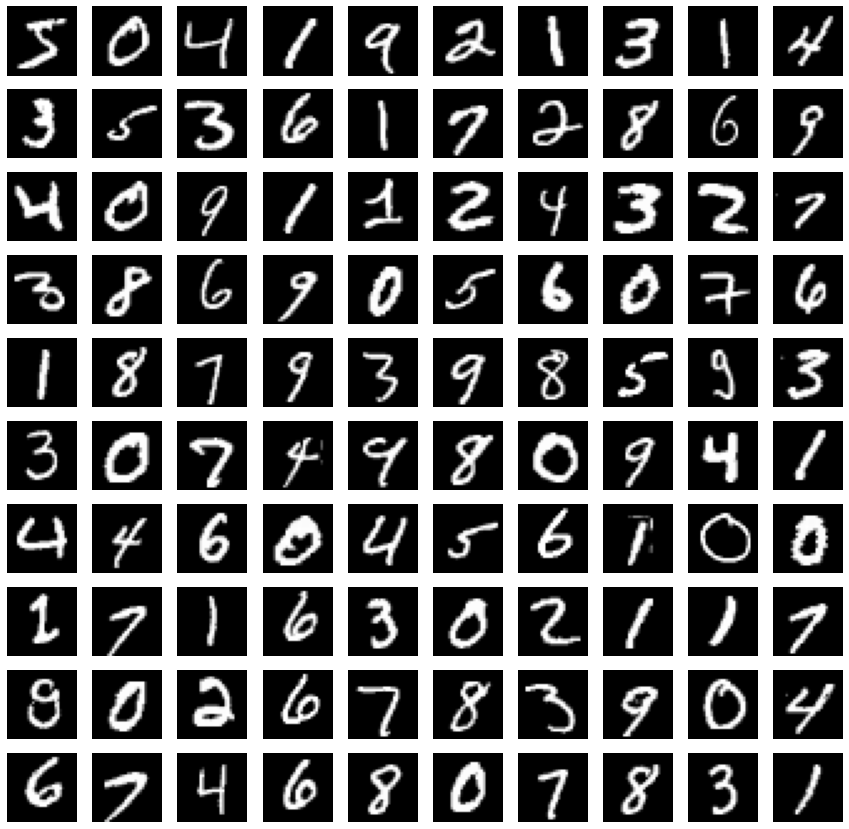

In [33]:
pyplot.figure(figsize=(15,15))
for i in range(100):
	# define subplot
	pyplot.subplot(10, 10, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(X[i, :, :, 0], cmap='gray')

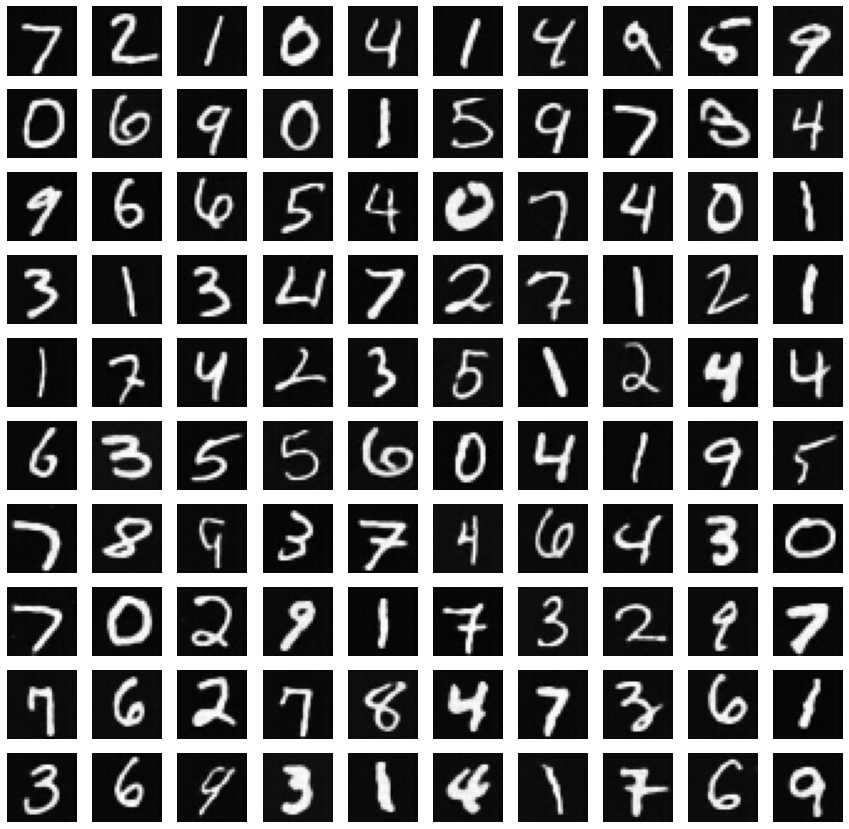

In [34]:
pyplot.figure(figsize=(15,15))
for i in range(100):
	# define subplot
	pyplot.subplot(10, 10, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(decoded_data[i, :, :, 0], cmap='gray')

**References:**

https://machinelearningmastery.com/semi-supervised-generative-adversarial-network/

https://keras.io/examples/generative/vae/